In [22]:
import pandas as pd 
import numpy as np 
import os 
import sys
import re
import json 
import string

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
wikivoyage_dir = "../../../../european-city-data/data-sources/wikivoyage/listings/"
cities = pd.read_csv("../../../../european-city-data/archive/city_abstracts_embeddings.csv")

In [59]:
listings = pd.read_csv(f"{wikivoyage_dir}/wikivoyage-listings-cleaned.csv")
things_to_do = listings[listings['type'].isin(['do', 'see', 'go'])]

things_to_do = things_to_do[things_to_do['description'] != "No description found."]
things_to_do['description_processed'] = things_to_do['title'] + ": " + things_to_do['description']
things_to_do.dropna(subset=['description_processed'], inplace=True)

In [60]:
things_to_do.head()

,city,type,title,description,description_processed
0,Aalborg,see,Aalborg Akvavit,Distillery.,Aalborg Akvavit: Distillery.
1,Aalborg,see,Aalborghus Castle,A castle and garden from the 16th century.,Aalborghus Castle: A castle and garden from th...
3,Aalborg,see,Aalborg Townhall,Built in 1759.,Aalborg Townhall: Built in 1759.
4,Aalborg,see,Aalborg Zoo,"Cosy zoo with many ""classic"" zoo animals such ...","Aalborg Zoo: Cosy zoo with many ""classic"" zoo ..."
8,Aalborg,see,Elbjørn,Icebreaker now working as a restaurant and cul...,Elbjørn: Icebreaker now working as a restauran...


In [61]:
def preprocess(text):
    # Lowercase the text
    try:
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        # Rejoin the tokens into a string
        return ' '.join(tokens)
    except Exception as e: 
        print(text)
        return ''

things_to_do['description_processed'] = things_to_do['description_processed'].apply(preprocess)

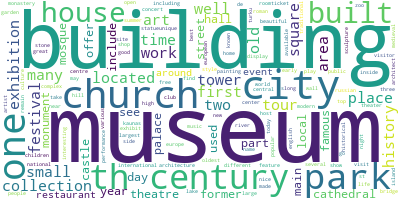

In [62]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(things_to_do['description_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [47]:
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = things_to_do.description_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

In [48]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1)]


In [49]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"city" + 0.006*"also" + 0.006*"church" + 0.006*"th" + 0.006*"museum" '
  '+ 0.005*"built" + 0.005*"tower" + 0.005*"collection" + 0.004*"art" + '
  '0.004*"century"'),
 (1,
  '0.009*"museum" + 0.008*"one" + 0.008*"building" + 0.006*"also" + '
  '0.005*"church" + 0.004*"city" + 0.004*"built" + 0.004*"history" + '
  '0.004*"old" + 0.004*"area"'),
 (2,
  '0.007*"one" + 0.006*"built" + 0.004*"art" + 0.003*"well" + 0.003*"festival" '
  '+ 0.003*"theater" + 0.003*"centre" + 0.003*"small" + 0.003*"best" + '
  '0.003*"main"'),
 (3,
  '0.011*"built" + 0.009*"th" + 0.009*"century" + 0.008*"city" + 0.006*"one" + '
  '0.006*"church" + 0.006*"small" + 0.005*"mosque" + 0.005*"building" + '
  '0.004*"style"'),
 (4,
  '0.008*"old" + 0.008*"century" + 0.007*"th" + 0.005*"city" + 0.005*"museum" '
  '+ 0.005*"built" + 0.005*"building" + 0.004*"tower" + 0.004*"one" + '
  '0.003*"art"'),
 (5,
  '0.011*"city" + 0.008*"built" + 0.008*"park" + 0.007*"church" + 0.006*"one" '
  '+ 0.005*"museum" + 

In [51]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.014437  0.016541       1        1  15.450113
1     -0.016637  0.009149       2        1  13.307857
7      0.002892 -0.013513       3        1  11.916473
5      0.002660  0.023524       4        1  10.039595
0      0.003450  0.010250       5        1   9.905800
6      0.018234  0.004069       6        1   9.190049
3     -0.039002  0.020100       7        1   8.860977
9     -0.015871  0.028434       8        1   8.739478
2      0.087673 -0.011670       9        1   6.399566
4     -0.028962 -0.086883      10        1   6.190093, topic_info=            Term        Freq       Total Category  logprob  loglift
4             th  379.000000  379.000000  Default  30.0000  30.0000
2        century  333.000000  333.000000  Default  29.0000  29.0000
5          built  395.000000  395.000000  Default  28.0000  28.0000
125       mosque  103.000000  103.000000  Default  27.0000  27.0000
78           art  268.000000  268.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
466       former    8.623744   96.945902  Topic10  -6.2071   0.3626
561       church   12.863812  380.007796  Topic10  -5.8072  -0.6036
629         park   10.840662  256.935668  Topic10  -5.9783  -0.3833
67      national    8.175048   94.137862  Topic10  -6.2605   0.3385
765  exhibitions    8.370199  109.633557  Topic10  -6.2369   0.2098

[833 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
10326      9  0.870493     acronym
11366      3  0.568713  admittance
555        2  0.189182    adriatic
555        3  0.567546    adriatic
555        7  0.189182    adriatic
...      ...       ...         ...
6929       5  0.139175       замок
6929       7  0.139175       замок
6929       8  0.417525       замок
6929      10  0.139175       замок
13101      2  0.731405   троіцькии

[2377 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 8, 6, 1, 7, 4, 10, 3, 5])

In [63]:
from bertopic import BERTopic

In [91]:
docs = things_to_do['description_processed']
# topic_model = BERTopic(nr_topics="auto") # error with bertopic, not fixed yet as 28.08.2024; pip install correct version once fixed: https://github.com/MaartenGr/BERTopic/issues/2100
topic_model = BERTopic(nr_topics=11, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(docs)

In [92]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,900,-1_museum_city_art_also,"[museum, city, art, also, building, park, one,...",[biological museum turku biological museum dio...
1,0,674,0_church_built_mosque_th,"[church, built, mosque, th, cathedral, century...",[mindszent parish church mindszent separate sm...
2,1,376,1_museum_collection_art_de,"[museum, collection, art, de, history, works, ...",[lviv art gallery divided several departments ...
3,2,348,2_festival_theatre_music_theater,"[festival, theatre, music, theater, concerts, ...",[holland festival performing arts festival bri...
4,3,291,3_park_city_tour_pool,"[park, city, tour, pool, tours, also, ice, ava...",[ali demi skate park alidemi skate park great ...
5,4,27,4_zoo_animals_species_berlin,"[zoo, animals, species, berlin, park, aquarium...",[aalborg zoo cosy zoo many classic zoo animals...
6,5,27,5_christmas_turku_fair_marathon,"[christmas, turku, fair, marathon, nurmi, paav...",[turku international book fair turku internati...
7,6,25,6_football_team_stadium_league,"[football, team, stadium, league, games, clubs...",[traditional games croke park stadium catch hu...
8,7,18,7_bridge_river_dragon_bridges,"[bridge, river, dragon, bridges, road, old, us...","[çatalan bridge longest bridge turkey, tanners..."
9,8,17,8_garden_botanical_plants_species,"[garden, botanical, plants, species, universit...",[botanical garden nice parc many interesting p...


In [93]:
topic_model.visualize_topics()

/Users/adithisatish/TUM/Academics/SoSe24/guided_research/.env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [94]:
topic_model.update_topics(docs, n_gram_range=(1, 3))
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,900,-1_museum_city_art_also,"[museum, city, art, also, building, park, one,...",[biological museum turku biological museum dio...
1,0,674,0_church_built_mosque_th,"[church, built, mosque, th, century, cathedral...",[mindszent parish church mindszent separate sm...
2,1,376,1_museum_art_collection_de,"[museum, art, collection, de, history, th, wor...",[lviv art gallery divided several departments ...
3,2,348,2_festival_theatre_music_theater,"[festival, theatre, music, theater, concerts, ...",[holland festival performing arts festival bri...
4,3,291,3_park_city_tour_pool,"[park, city, tour, pool, tours, also, one, ice...",[ali demi skate park alidemi skate park great ...
5,4,27,4_zoo_animals_park_species,"[zoo, animals, park, species, berlin, children...",[aalborg zoo cosy zoo many classic zoo animals...
6,5,27,5_turku_christmas_fair_marathon,"[turku, christmas, fair, marathon, nurmi, even...",[turku international book fair turku internati...
7,6,25,6_football_team_stadium_league,"[football, team, stadium, league, games, clubs...",[traditional games croke park stadium catch hu...
8,7,18,7_bridge_river_dragon_bridges,"[bridge, river, dragon, bridges, old, dragon b...","[çatalan bridge longest bridge turkey, tanners..."
9,8,17,8_garden_botanical_botanical garden_plants,"[garden, botanical, botanical garden, plants, ...",[botanical garden nice parc many interesting p...


In [95]:
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")

In [96]:
topic_model.update_topics(docs, topics=new_topics)

2024-08-28 12:12:57,200 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [97]:
topics_df = topic_model.get_topic_info()

In [98]:
topics_df.head()

,Topic,Count,Name,Representation,Representative_Docs
0,0,950,0_church_built_th_century,"[church, built, th, century, mosque, cathedral...",[mindszent parish church mindszent separate sm...
1,1,678,1_museum_art_collection_history,"[museum, art, collection, history, de, exhibit...",[lviv art gallery divided several departments ...
2,2,422,2_festival_theatre_music_theater,"[festival, theatre, music, theater, concerts, ...",[holland festival performing arts festival bri...
3,3,532,3_park_city_lake_also,"[park, city, lake, also, tour, one, pool, area...",[ali demi skate park alidemi skate park great ...
4,4,27,4_zoo_animals_species_berlin,"[zoo, animals, species, berlin, park, aquarium...",[aalborg zoo cosy zoo many classic zoo animals...


In [99]:
topics_df['label'] = topics_df['Name'].apply(lambda x: '_'.join(x.split("_")[1:]))
topics_df.head(11)

,Topic,Count,Name,Representation,Representative_Docs,label
0,0,950,0_church_built_th_century,"[church, built, th, century, mosque, cathedral...",[mindszent parish church mindszent separate sm...,church_built_th_century
1,1,678,1_museum_art_collection_history,"[museum, art, collection, history, de, exhibit...",[lviv art gallery divided several departments ...,museum_art_collection_history
2,2,422,2_festival_theatre_music_theater,"[festival, theatre, music, theater, concerts, ...",[holland festival performing arts festival bri...,festival_theatre_music_theater
3,3,532,3_park_city_lake_also,"[park, city, lake, also, tour, one, pool, area...",[ali demi skate park alidemi skate park great ...,park_city_lake_also
4,4,27,4_zoo_animals_species_berlin,"[zoo, animals, species, berlin, park, aquarium...",[aalborg zoo cosy zoo many classic zoo animals...,zoo_animals_species_berlin
5,5,34,5_turku_christmas_fair_marathon,"[turku, christmas, fair, marathon, nurmi, even...",[turku international book fair turku internati...,turku_christmas_fair_marathon
6,6,25,6_football_team_stadium_league,"[football, team, stadium, league, games, clubs...",[traditional games croke park stadium catch hu...,football_team_stadium_league
7,7,18,7_bridge_river_dragon_bridges,"[bridge, river, dragon, bridges, road, old, us...","[çatalan bridge longest bridge turkey, tanners...",bridge_river_dragon_bridges
8,8,17,8_garden_botanical_plants_species,"[garden, botanical, plants, species, universit...",[botanical garden nice parc many interesting p...,garden_botanical_plants_species
9,9,12,9_roman_pompeii_ad_vesuvius,"[roman, pompeii, ad, vesuvius, city, site, rd,...",[scythian neapolis scythian neapolis settlemen...,roman_pompeii_ad_vesuvius


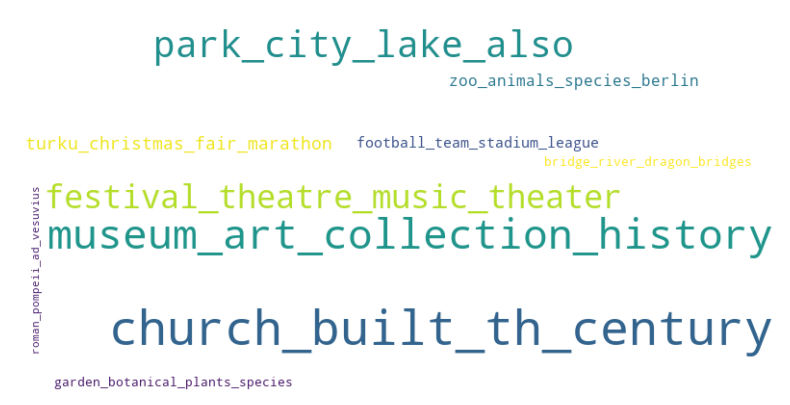

In [100]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Convert the labels and counts into a dictionary
word_freq = dict(zip(topics_df['label'], topics_df['Count']))

# Create the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [101]:
topic_model.save("wikivoyage_listings_topics", serialization="pickle")

2024-08-28 12:12:58,505 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [111]:
for i in topics_df['Representation']:
    print(i)

['church', 'built', 'th', 'century', 'mosque', 'cathedral', 'building', 'st', 'tower', 'city']
['museum', 'art', 'collection', 'history', 'de', 'exhibitions', 'th', 'building', 'works', 'century']
['festival', 'theatre', 'music', 'theater', 'concerts', 'international', 'cinema', 'opera', 'jazz', 'film']
['park', 'city', 'lake', 'also', 'tour', 'one', 'pool', 'area', 'place', 'small']
['zoo', 'animals', 'species', 'berlin', 'park', 'aquarium', 'children', 'zoos', 'monkeys', 'wilhelma']
['turku', 'christmas', 'fair', 'marathon', 'nurmi', 'event', 'run', 'paavo', 'market', 'competition']
['football', 'team', 'stadium', 'league', 'games', 'clubs', 'home', 'play', 'match', 'rugby']
['bridge', 'river', 'dragon', 'bridges', 'road', 'old', 'used', 'two', 'calendar', 'arch']
['garden', 'botanical', 'plants', 'species', 'university', 'tropical', 'trees', 'greenhouse', 'botanic', 'arboretum']
['roman', 'pompeii', 'ad', 'vesuvius', 'city', 'site', 'rd', 'archeological', 'bc', 'ancient']


- Historic Religious Buildings: ['church', 'built', 'th', 'century', 'mosque', 'cathedral', 'building', 'st', 'tower', 'city']
- Museums and Art Galleries: ['museum', 'art', 'collection', 'history', 'de', 'exhibitions', 'th', 'building', 'works', 'century']
- Music, Theater and Cultural Festivals: ['festival', 'theatre', 'music', 'theater', 'concerts', 'international', 'cinema', 'opera', 'jazz', 'film']
- Parks and Natural Spaces: ['park', 'city', 'lake', 'also', 'tour', 'one', 'pool', 'area', 'place', 'small']
- Zoos and Wildlife: ['zoo', 'animals', 'species', 'berlin', 'park', 'aquarium', 'children', 'zoos', 'monkeys', 'wilhelma']
- Markets and Fairs: ['turku', 'christmas', 'fair', 'marathon', 'nurmi', 'event', 'run', 'paavo', 'market', 'competition']
- Sport: ['football', 'team', 'stadium', 'league', 'games', 'clubs', 'home', 'play', 'match', 'rugby']
- Bridges and Landmarks: ['bridge', 'river', 'dragon', 'bridges', 'road', 'old', 'used', 'two', 'calendar', 'arch']
- Tropical and Botanical Gardens: ['garden', 'botanical', 'plants', 'species', 'university', 'tropical', 'trees', 'greenhouse', 'botanic', 'arboretum']
- Archaeological and Ancient Ruins: ['roman', 'pompeii', 'ad', 'vesuvius', 'city', 'site', 'rd', 'archeological', 'bc', 'ancient']

In [112]:
topic_labels = {
    0: "Historic Religious Buildings",
    1: "Museums and Art Galleries",
    2: "Music, Theater and Cultural Festivals",
    3: "Parks and Natural Spaces",
    4: "Zoos and Wildlife",
    5: "Markets and Fairs",
    6: "Sport", 
    7: "Bridges and Landmarks",
    8: "Tropical and Botanical Gardens",
    9: "Archaeological and Ancient Ruins"
}

topic_model.set_topic_labels(topic_labels=topic_labels)

In [114]:
new_topics_df = topic_model.get_topic_info()
new_topics_df

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,950,0_church_built_th_century,Historic Religious Buildings,"[church, built, th, century, mosque, cathedral...",[mindszent parish church mindszent separate sm...
1,1,678,1_museum_art_collection_history,Museums and Art Galleries,"[museum, art, collection, history, de, exhibit...",[lviv art gallery divided several departments ...
2,2,422,2_festival_theatre_music_theater,"Music, Theater and Cultural Festivals","[festival, theatre, music, theater, concerts, ...",[holland festival performing arts festival bri...
3,3,532,3_park_city_lake_also,Parks and Natural Spaces,"[park, city, lake, also, tour, one, pool, area...",[ali demi skate park alidemi skate park great ...
4,4,27,4_zoo_animals_species_berlin,Zoos and Wildlife,"[zoo, animals, species, berlin, park, aquarium...",[aalborg zoo cosy zoo many classic zoo animals...
5,5,34,5_turku_christmas_fair_marathon,Markets and Fairs,"[turku, christmas, fair, marathon, nurmi, even...",[turku international book fair turku internati...
6,6,25,6_football_team_stadium_league,Sport,"[football, team, stadium, league, games, clubs...",[traditional games croke park stadium catch hu...
7,7,18,7_bridge_river_dragon_bridges,Bridges and Landmarks,"[bridge, river, dragon, bridges, road, old, us...","[çatalan bridge longest bridge turkey, tanners..."
8,8,17,8_garden_botanical_plants_species,Tropical and Botanical Gardens,"[garden, botanical, plants, species, universit...",[botanical garden nice parc many interesting p...
9,9,12,9_roman_pompeii_ad_vesuvius,Archaeological and Ancient Ruins,"[roman, pompeii, ad, vesuvius, city, site, rd,...",[scythian neapolis scythian neapolis settlemen...


/var/folders/07/81pmlyln5szbq49h1zdqjq1h0000gn/T/ipykernel_47755/4060544887.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/07/81pmlyln5szbq49h1zdqjq1h0000gn/T/ipykernel_47755/4060544887.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



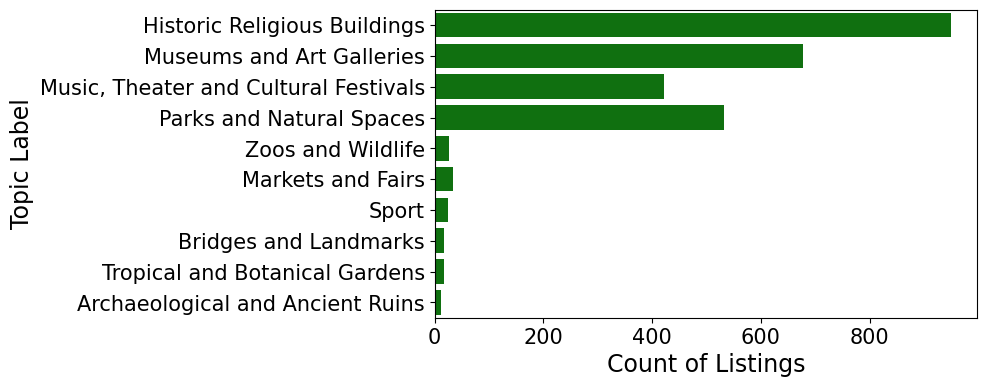

In [232]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(7,4))
plot = sns.barplot(data=new_topics_df, x='Count', y='CustomName', errorbar=None, color='green', orient='h')
# plot.set_title('Topic Labels and their Counts for ', fontsize=15)
# plot.set_xticklabels(['Pleasant', 'Unpleasant', 'Appearance Words', 'Intelligence Words', 'Strength Words', 'Weakness Words'])
plot.set_ylabel(ylabel="Topic Label", fontsize=17)
plot.set_xlabel(xlabel="Count of Listings", fontsize=17)
plot.set_yticklabels(plot.get_yticklabels(), fontsize=15)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=15)
# plot.set_title("Topic Clusters of Attractions for the 160 European cities, generated by BERTopic")
plt.savefig("topic_counts.pdf", bbox_inches='tight')

In [138]:
with open("../../../../european-city-data/data-sources/wikivoyage/original/20053_London.txt", "r") as f:
    london_text = f.read()


In [141]:
with open("../../../../european-city-data/data-sources/wikivoyage/original/26799_Paris.txt", "r") as f:
    paris_text = f.read()

In [222]:
# Step 1: Preprocess the Text
# Convert text to lowercase
def wv_wordcloud(text, city, subplot=False):
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'\W+', ' ', text)

    # Remove stopwords
    stop_words = stopwords.words('english')
    stop_words.extend([
        'lastedit', 'url', 'http', 'https', 'content', 'lat', \
        'long', 'com', 'org', 'alt', 'listing', "fax", "tollfree",\
        "phone", 'email', 'address', 'flag', 'city', 'name', "jpg", "png", \
        "wikidata", 'img', 'image', "arr", "dead link",
        ])
    processed_text = ' '.join(word for word in text.split() if word not in stop_words)

    # Step 2: Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)
    

    # Step 3: Display the WordCloud
    if not subplot:
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f"Wordcloud of the Wikivoyage Article page for {city}")
        # plt.show()
        plt.savefig(f"wordcloud_{city.lower()}.pdf")
    else:
        return wordcloud

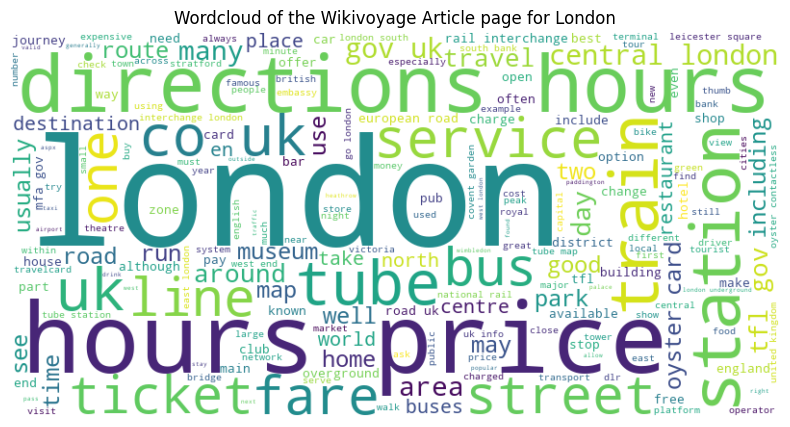

In [223]:
wv_wordcloud(london_text, "London")

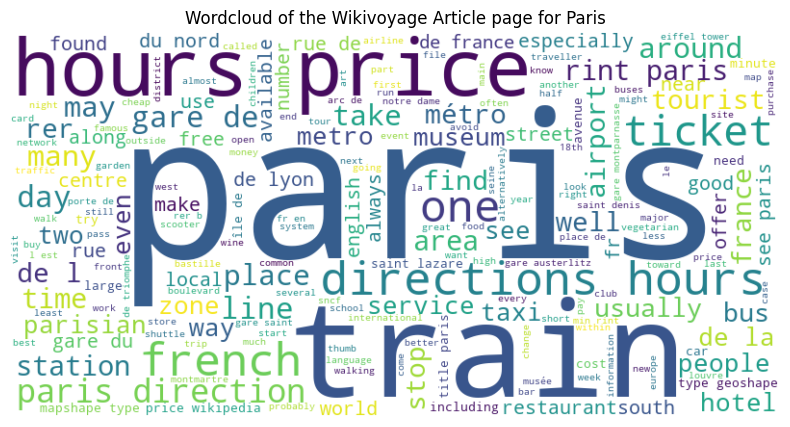

In [224]:
wv_wordcloud(paris_text, "Paris")

In [198]:
with open("../../../../european-city-data/data-sources/wikivoyage/original/29990_Rome.txt", "r") as f:
    rome_text = f.read()

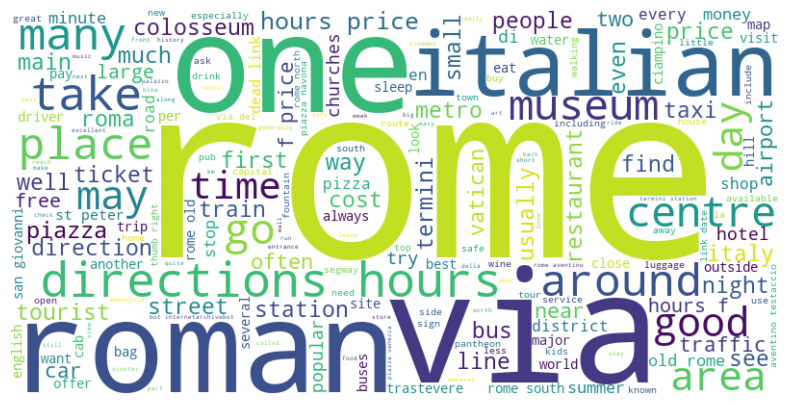

In [199]:
wv_wordcloud(rome_text)

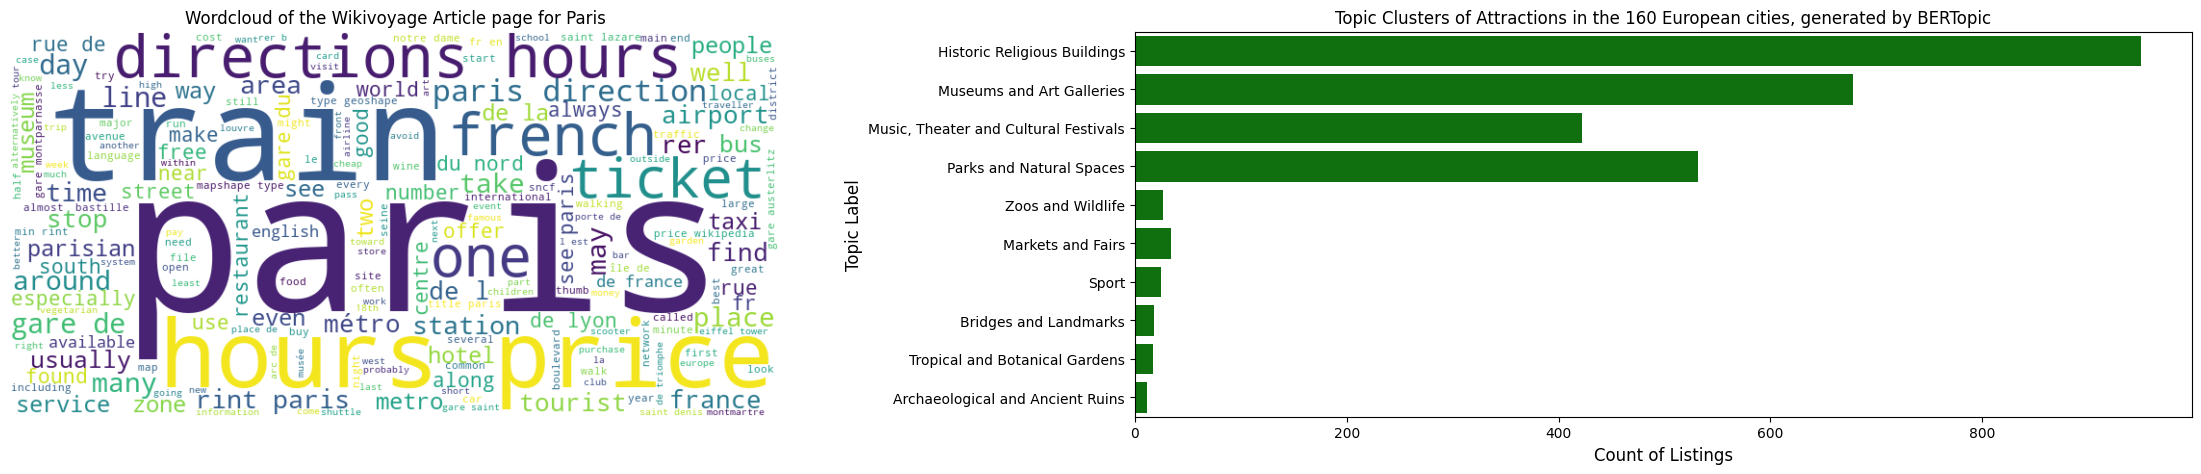

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(30,5), sharey=False)

wordcloud = wv_wordcloud(paris_text, subplot=True)
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis('off')
ax[0].set_title("Wordcloud of the Wikivoyage Article page for Paris")
ax[0].patch.set_edgecolor('black')  
ax[0].patch.set_linewidth(10)  

bar = sns.barplot(ax=ax[1],data=new_topics_df, x='Count', y='CustomName', errorbar=None, color='green', orient='h')
# plot.set_title('Topic Labels and their Counts for ', fontsize=15)
# plot.set_xticklabels(['Pleasant', 'Unpleasant', 'Appearance Words', 'Intelligence Words', 'Strength Words', 'Weakness Words'])
bar.set_ylabel(ylabel="Topic Label", fontsize=12)
bar.set_xlabel(xlabel="Count of Listings", fontsize=12)
bar.set_title("Topic Clusters of Attractions in the 160 European cities, generated by BERTopic")

plt.show()

In [102]:
seasonality = pd.read_csv("../../../../european-city-data/computed/seasonality/seasonality_scores.csv")
popularity = pd.read_csv("../../../../european-city-data/computed/popularity/popularity_scores.csv")

In [103]:
seasonality.head()

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Aalborg,0.016,0.000,0.031,0.173,0.496,0.685,1.000,0.827,0.496,0.378,0.244,0.087
1,Adana,0.000,0.062,0.215,0.757,0.938,0.639,0.875,0.910,0.875,1.000,0.819,0.938
2,Adiyaman,0.000,0.022,0.104,0.433,0.619,0.485,0.918,1.000,0.649,0.649,0.246,0.269
3,Agri,0.000,0.022,0.104,0.433,0.619,0.485,0.918,1.000,0.649,0.649,0.246,0.269
4,Amsterdam,0.434,0.000,0.170,0.132,0.075,0.019,0.642,0.075,1.000,0.943,0.302,0.698


In [104]:
popularity.head()

,city,pois,avg_gt,ugc,normalized_gt,normalized_ugc,normalized_poi,weighted_pop_score
0,Van,40,70.778,4901,1.000,0.001,0.004,0.208
1,Luxembourg,627,69.379,207447,0.980,0.029,0.070,0.244
2,Santander,234,65.812,136209,0.930,0.019,0.026,0.210
3,Maastricht,244,64.644,107940,0.913,0.015,0.027,0.206
4,Kiel,173,62.946,20770,0.889,0.003,0.019,0.193


In [105]:
seasonality[seasonality['city'] == 'Munich']

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
105,Munich,0.038,0.0,0.162,0.015,0.092,0.215,0.192,0.185,1.0,0.315,0.008,0.192


In [107]:
seasonality['total'] = seasonality.iloc[:, -12:-1].sum(axis=1)
seasonality.sort_values(by='total', ascending=False)

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total
1,Adana,0.000,0.062,0.215,0.757,0.938,0.639,0.875,0.910,0.875,1.000,0.819,0.938,8.028
130,Poznan,0.000,0.246,0.438,0.608,0.854,0.838,0.838,0.815,1.000,0.854,0.477,0.562,7.530
17,Batman,0.000,0.415,0.933,0.963,1.000,0.770,0.741,0.711,0.511,0.452,0.289,0.415,7.200
62,Hamburg,0.152,0.000,0.176,0.592,0.824,0.808,1.000,1.000,0.896,0.744,0.416,0.720,7.176
59,Gaziantep,0.000,0.077,0.317,0.808,1.000,0.683,0.808,0.808,0.654,0.913,0.548,0.529,7.145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Geneva,0.000,0.028,0.056,0.111,0.111,0.167,0.000,0.028,1.000,0.667,0.111,0.333,2.612
105,Munich,0.038,0.000,0.162,0.015,0.092,0.215,0.192,0.185,1.000,0.315,0.008,0.192,2.376
135,Riga,0.293,0.000,0.293,0.049,0.098,0.195,0.024,0.073,0.488,0.073,0.024,1.000,2.317
157,Stockholm,0.126,0.046,0.115,0.069,1.000,0.092,0.000,0.034,0.276,0.161,0.126,0.379,2.298


In [108]:
seasonality[seasonality['city'] == 'Brussels']

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total
30,Brussels,0.227,0.12,0.187,0.253,0.027,0.04,0.0,0.027,1.0,0.533,0.293,0.773,3.253


In [110]:
popularity.sort_values(by="weighted_pop_score", ascending=False)

,city,pois,avg_gt,ugc,normalized_gt,normalized_ugc,normalized_poi,weighted_pop_score
45,London,8999,29.176,7099844,0.412,1.000,1.000,0.879
39,Paris,8806,34.851,5065682,0.492,0.713,0.979,0.792
41,Rome,6328,34.391,5657815,0.486,0.797,0.703,0.689
37,Barcelona,5062,36.126,3517752,0.510,0.495,0.563,0.530
148,Moscow,8003,0.900,808984,0.013,0.114,0.889,0.457
...,...,...,...,...,...,...,...,...
166,Rivne,48,0.119,1297,0.002,0.000,0.005,0.003
198,Arkhangelsk,0,0.592,9526,0.008,0.001,0.000,0.002
176,Siirt,11,0.008,217,0.000,0.000,0.001,0.001
180,Adiyaman,16,0.004,2113,0.000,0.000,0.002,0.001
